In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import BatchNormalization
# コード先頭に追加
import numpy as np
import random

# シード値を固定
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# 🐱🐶 画像分類モデルの学習
print(Sequential)
# GPUがあるか確認して、あればメモリ制限
print(device_lib.list_local_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("✅ GPUが見つかりました")
    try:
        # 動的メモリ割り当てを有効化
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPUメモリの動的割り当てを設定しました")
    except RuntimeError as e:
        print("❌ メモリ設定に失敗しました：", e)
        
# 🟡 ここに設定をまとめておくと便利！
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE =16
EPOCHS = 25 # 「全部の画像 × 3周」を学習って感じニャ！
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)  # 画像の縦・横・チャンネル数

train_dir = 'dataset/train'
val_dir = 'dataset/validation'

# 📁 データの前処理
'''
「画像の画素値を 0〜1の範囲に正規化 するよ！」という設定にゃ！
元の画像って、1ピクセルあたり 0〜255 の値を持ってるけど
→ ニューラルネットは 小さい値の方が学習しやすいので
→ 0〜1の範囲に収めることで学習がスムーズに進むにゃ！
datagenはこれは開発者が自由に付けてる変数名だけど、
data + generator = datagen って感じで「データを生成するもの」って感じにゃ！
train_datagen → 学習用のデータを生成してくれるオブジェクト
val_datagen → 検証用の画像は変形せず、正規化だけして使うことが多いにゃ！
'''
# 訓練用ジェネレーター（オーグメンテーション付き）
# オーグメンテーション（回転やズームなど）をかけながら、ランダムに画像を取り出して学習させる
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# ディレクトリから画像を読み込む
train_generator = train_datagen.flow_from_directory(
    train_dir,  # 訓練データのパス
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)



<class 'keras.engine.sequential.Sequential'>
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14879683210243558696
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10063183872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14292967810755028116
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
✅ GPUが見つかりました
✅ GPUメモリの動的割り当てを設定しました
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [2]:
# 🧠 モデル構築

model = Sequential([
    # 第1層: 畳み込み + 活性化 + プーリング
    Conv2D(64, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),

    # 第2層: 畳み込み + 活性化 + プーリング（レイヤーを増やすことで特徴抽出の精度が向上するニャン）
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # 中間に追加ニャ！
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(500, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # BatchNormalization()は、学習を安定させるためのものにゃ！
    # 平坦化して全結合層へ
    Flatten(),

    # 全結合層
    Dense(256, activation='relu'),
    Dropout(0.5),  # 過学習対策としてDropoutを追加するにゃ！
    Dense(1, activation='sigmoid')  # 2クラス分類なのでシグモイド
])

print("モデルの構築が完了しました！")


モデルの構築が完了しました！


In [3]:
# 🛠️ コンパイル
# 二値分類問題なので、binary_crossentropyを使う
#11分類になったら categorical_crossentropy + class_mode='categorical' に変更必要
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
print("モデルのコンパイルが完了しました！")

モデルのコンパイルが完了しました！


In [ ]:
# モデル学習 
try:
    # バッチごとに処理を試す最小限の設定
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        workers=1,
        use_multiprocessing=False
    )
    print("✅ モデル学習が正常に完了しました")
    
    # 学習成功時にモデル保存
    model.save('cat_dog_model.h5')
    print("モデルを cat_dog_model.h5 に保存しましたにゃ！")
    
except Exception as e:
    print(f"❌ エラーが発生しました: {str(e)}")
    model.save('cat_dog_model_error.h5')

Epoch 1/25
1250/1250 [==============================] - 46s 33ms/step - loss: 0.9921 - accuracy: 0.5389 - val_loss: 23.8866 - val_accuracy: 0.5004
Epoch 2/25
1250/1250 [==============================] - 36s 29ms/step - loss: 0.6937 - accuracy: 0.5313 - val_loss: 1.1378 - val_accuracy: 0.5670
Epoch 3/25
1250/1250 [==============================] - 36s 29ms/step - loss: 0.6922 - accuracy: 0.5288 - val_loss: 1.5514 - val_accuracy: 0.5254
Epoch 4/25
1250/1250 [==============================] - 36s 29ms/step - loss: 0.6902 - accuracy: 0.5422 - val_loss: 0.6664 - val_accuracy: 0.6250
Epoch 5/25
1250/1250 [==============================] - 37s 29ms/step - loss: 0.6906 - accuracy: 0.5530 - val_loss: 0.7294 - val_accuracy: 0.5098
Epoch 6/25
1250/1250 [==============================] - 37s 29ms/step - loss: 0.6878 - accuracy: 0.5483 - val_loss: 0.6941 - val_accuracy: 0.5024
Epoch 7/25
1250/1250 [==============================] - 37s 30ms/step - loss: 0.6803 - accuracy: 0.5623 - val_loss: 0.6641 

In [ ]:
# 🧪 モデル評価
# "validation" フォルダの中にある画像を使って、モデルの評価を行うにゃ！
# ➊ 検証用ジェネレーターを作成（shuffle=False でファイル順に対応）
# 画像に手を加えずに、そのまま順番に取り出して評価する
val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# ➊ モデルの評価（検証データ全体での最終的な loss と accuracy を取得）
loss_eval, acc_eval = model.evaluate(val_gen, verbose=1)
print(f"▶ 最終検証損失: {loss_eval:.4f}")
print(f"▶ 最終検証精度: {acc_eval:.4f}")
print("▶ モデルの評価が完了しましたにゃ！")

from datetime import datetime
fname = f"cat_dog_{datetime.now():%Y%m%d_%H%M}_acc{acc_eval:.2f}.h5"
model.save(fname)
print(f"モデルを {fname} に保存しました🐾")

Found 5000 images belonging to 2 classes.
313/313 [==============================] - 2s 7ms/step - loss: 0.2521 - accuracy: 0.8980
▶ 最終検証損失: 0.2521
▶ 最終検証精度: 0.8980
▶ モデルの評価が完了しましたにゃ！


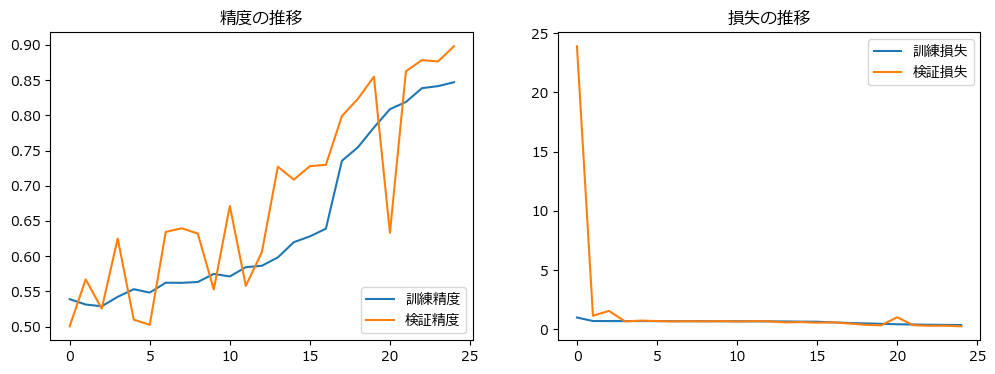

5000/5000 [==============================] - 6s 1ms/step
▶ classification_results.csv に書き出しましたにゃ！


In [6]:
# 📊 学習結果の可視化
import matplotlib.pyplot as plt
# フォント設定（例：Windows + メイリオ）
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# 学習過程の損失と精度をプロット
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

# 精度のグラフ
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='訓練精度')
plt.plot(epochs_range, val_acc, label='検証精度')
plt.legend(loc='lower right')
plt.title('精度の推移')

# 損失のグラフ
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='訓練損失')
plt.plot(epochs_range, val_loss, label='検証損失')
plt.legend(loc='upper right')
plt.title('損失の推移')

plt.show()

# 6. 予測結果を CSV に出力
import pandas as pd
preds       = model.predict(val_gen, steps=len(val_gen), verbose=1)
pred_labels = (preds >= 0.5).astype(int).flatten()
true_labels = val_gen.classes
filenames   = val_gen.filenames

df = pd.DataFrame({
    'filename': filenames,
    'true':     true_labels,
    'pred':     pred_labels
})
df['correct'] = df['true'] == df['pred']
df.to_csv('classification_results.csv', index=False)
print("▶ classification_results.csv に書き出しましたにゃ！")
